# MonthlySVD
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell
- calculate singular value decomposition by grid cell, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils
import segment as sg
import scipy                    # Try scipy to detrend
from scipy import signal

# some resources for plotting
import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs
%matplotlib inline

In [2]:
import warnings
# supress Runtime warnings that let you know when code isn't too efficiently
warnings.simplefilter("ignore", category=RuntimeWarning)
#warnings.simplefilter("ignore", category=PerformanceWarning)

# TODO, turn warmings back on with code below? 
#warnings.resetwarnings()

## ---- Read in data ----

In [3]:
## User defined options
# not looking at TWS, instead of surface water content.

var  = ['GPP','TBOT', 'TWS']#'SOILWATER_10CM']
suff = '/lnd/proc/tseries/month_1/'

# TODO, this is a pretty inefficient way to look at multiple simulations / models
#       but until the SVD calculation is faster it may not be worth trying to look at multiple models at once
#       JH, suggestions here would also be welcome.
## For Keith's CLM5 GSWP3 simulations
model =('CLM5_GSWP3', 'CLM45_GSWP3')
case = ('clm50_r270_1deg_GSWP3V1_iso_newpopd_hist',
         'clm45_r270_1deg_GSWP3V1_hist')
path = ('/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/'+case[0]+suff,
        '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM4.5/'+case[1]+suff)

## For Keith's CLM4.5 GSWP3 simulations
#model = 'CLM45_GSWP3'
#case = 'clm45_r270_1deg_GSWP3V1_hist'
#path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM4.5/'+case+suff

file0 = path[0] + case[0] +'.clm2.h0.'+ var[0] +'.185001-201412.nc'
file1 = path[0] + case[0] +'.clm2.h0.'+ var[1] +'.185001-201412.nc'
file2 = path[0] + case[0] +'.clm2.h0.'+ var[2] +'.185001-201412.nc'

file0B = path[1] + case[1] +'.clm2.h0.'+ var[0] +'.185001-201412.nc'
file1B = path[1] + case[1] +'.clm2.h0.'+ var[1] +'.185001-201412.nc'
file2B = path[1] + case[1] +'.clm2.h0.'+ var[2] +'.185001-201412.nc'

## For Danica's no crop run
#model = 'CLM5_GSWP3 _noCrop'
#path = '/glade/p/cesm/lmwg_dev/dll/CLM5GSWP3_NoCrop/SingleVarTimeFiles/'
#file0 = path + 'clm50_r267_1deg_GSWP3V1_iso_hist_nocrop_transientfix.clm2.h0.'+ var[0] +'.185001-201012.nc'
#file1 = path + 'clm50_r267_1deg_GSWP3V1_iso_hist_nocrop_transientfix.clm2.h0.'+ var[1] +'.185001-201012.nc'
#file2 = path + 'clm50_r267_1deg_GSWP3V1_iso_hist_nocrop_transientfix.clm2.h0.'+ var[2] +'.185001-201012.nc'
print(file0)
# wrapping the time_set_mid utility corrects time being read in by xr.open_dataset
# data sets have lots of coords, variables, and attributes
# ?? TODO, is there a more efficient way of reading in multiple variables into a signle dataset??
ds0   = utils.time_set_mid(xr.open_dataset(file0, decode_times=True), 'time')
ds1   = utils.time_set_mid(xr.open_dataset(file1, decode_times=True), 'time')
ds2   = utils.time_set_mid(xr.open_dataset(file2, decode_times=True), 'time')

ds0B   = utils.time_set_mid(xr.open_dataset(file0B, decode_times=True), 'time')
ds1B   = utils.time_set_mid(xr.open_dataset(file1B, decode_times=True), 'time')
ds2B   = utils.time_set_mid(xr.open_dataset(file2B, decode_times=True), 'time')
ds = xr.merge([ds0, ds1, ds2])
dsB = xr.merge([ds0B, ds1B, ds2B])

area = ds0.area
landfrac = ds0.landfrac
#print(ds)

/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.GPP.185001-201412.nc


## --- This is example code to make sure things are working ---
###          Quick look at annual cycle for a grid cell

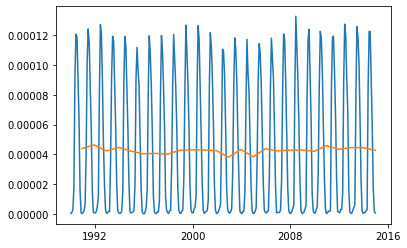

In [4]:
years = 25
months = years * 12
tlat = 60  #46  #-3
tlon = 240 #262 #280
ds_test = ds.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
ds_last = ds_test.isel(time=slice(-months,None))
dataset = ds_last.get(var)
ds_ann  = dataset.apply(utils.weighted_annual_mean)
plt.plot(ds_last.time['time'], ds_last.get(var[0]), '-' );
plt.plot(ds_ann.time['time'], ds_ann.get(var[0]), '-' );

#dsB_test = dsB.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
#dsB_last = dsB_test.isel(time=slice(-months,None))
#datasetB = dsB_last.get(var)
#dsB_ann  = datasetB.apply(utils.weighted_annual_mean)
#plt.plot(dsB_last.time['time'], dsB_last.get(var[0]), '-' );
#plt.plot(dsB_ann.time['time'], dsB_ann.get(var[0]), '-' );


### Calculate climatology and anomalies

In [5]:
# esmlab anomaly function needs time_bounds in the dataset!
# test to see of climatology and anomaly functions see to work appropriately?
ds_climo = esmlab.core.climatology(ds_last,freq='mon')
ds_anom = esmlab.core.anomaly(ds_last, clim_freq='mon', time_coord_name='time')
ds_detrend = ds_anom.get(var).map(signal.detrend)   # still need to use get so detrend works

#dsB_climo = esmlab.core.climatology(dsB_last,freq='mon')
#dsB_anom = esmlab.core.anomaly(dsB_last, clim_freq='mon', time_coord_name='time')
#dsB_detrend = dsB_anom.get(var).map(signal.detrend)   # still need to use get so detrend works

# resample monthly data to seasonal
ds_detrend_season = ds_detrend.resample(time="QS-DEC").mean()
#dsB_detrend_season = dsB_detrend.resample(time="QS-DEC").mean()


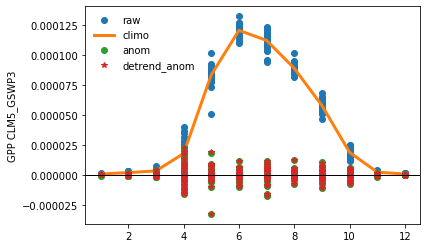

In [6]:
# JH doesn't like using generic variables here, but 
# I'm going leave this for now, because the analysis may not always focus on GPP.
plt.plot(ds_last.time['time.month'], ds_last.get(var[0]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[0]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[0]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[0]), '*' );
plt.legend(labels=('raw','climo','anom','detrend_anom'),frameon = False)
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[0]+" "+model[0]);

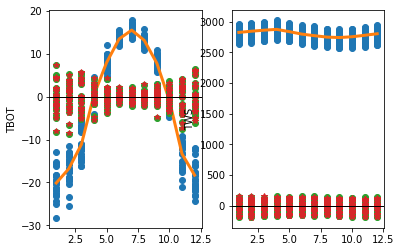

In [7]:
# now look at temp and soil moisture anomalies
plt.subplot(1, 2, 1)
plt.plot(ds_last.time['time.month'], ds_last.get(var[1])-273.15, 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[1])-273.15, '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[1]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[1]), '*' );
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[1])

plt.subplot(1, 2, 2)
plt.plot(ds_last.time['time.month'], ds_last.get(var[2]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[2]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[2]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend.get(var[2]), '*' );
plt.axhline(0., color='black', lw=1);
plt.ylabel(var[2]);

#### Seaonal GPP anomalies seem to show a similar pattern to TWS in CLM4.5 
#### Stonger temperature sensitivity w/ CLM5?

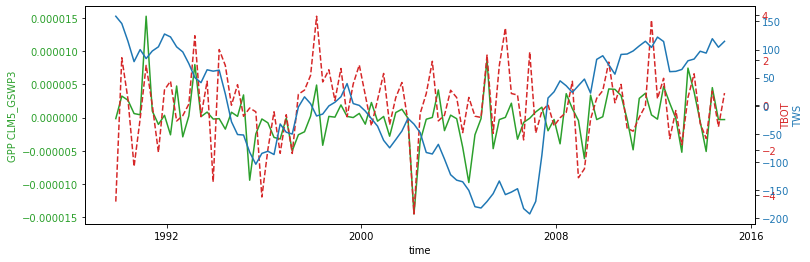

In [8]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,1,1)

color = 'tab:green'
ax1.set_xlabel('time')
ax1.set_ylabel(var[0]+" "+model[0], color=color)
ax1.plot(ds_detrend_season.time, ds_detrend_season.get(var[0]), '-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel(var[1], color=color)  # we already handled the x-label with ax1
ax2.plot(ds_detrend_season.time, ds_detrend_season.get(var[1]), '--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax3.set_ylabel(var[2], color=color)  # we already handled the x-label with ax1
ax3.plot(ds_detrend_season.time, ds_detrend_season.get(var[2]), '-', color=color)
ax3.tick_params(axis='y', labelcolor=color)
plt.show();



 ### Do we need to detrend data?

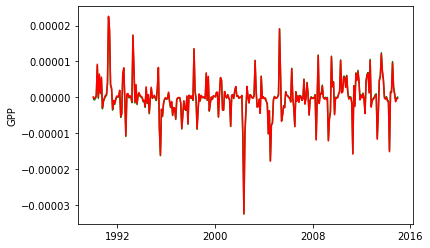

In [9]:
plt.plot(ds_anom.time['time'], ds_anom.get(var[0]), '-',c='green' )
plt.plot(ds_anom.time['time'], ds_detrend.get(var[0]), '-' ,c='red')
plt.ylabel(var[0]);

### Start singular vector decomposition
#### This is from Gretchen's CLM_SVD code 

(12, 25)


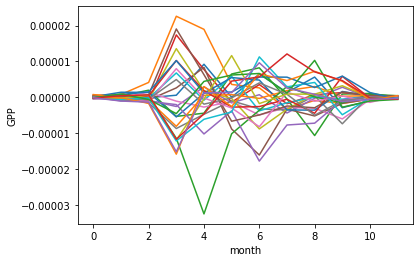

In [10]:
# orig. mon x year
iavmatrix_0 =np.zeros([12, years])
iavmatrix_1 =np.zeros([12, years])
iavmatrix_2 =np.zeros([12, years])
for iyr in range(years):
    iavmatrix_0[0:12, iyr]=ds_detrend.get(var[0])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
    iavmatrix_1[0:12, iyr]=ds_detrend.get(var[1])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
    iavmatrix_2[0:12, iyr]=ds_detrend.get(var[2])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 

print(iavmatrix_0.shape)

plt.figure();
plt.plot(iavmatrix_0) #this plots months on x-axis, 1 line/year
plt.ylabel(var[0])
plt.xlabel('month');

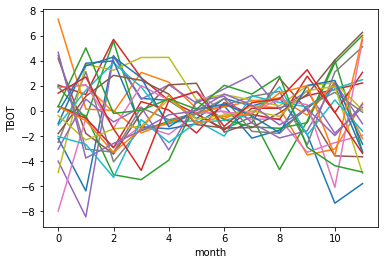

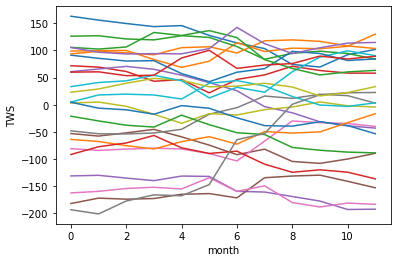

In [11]:
plt.figure();
plt.plot(iavmatrix_1) #this plots months on x-axis, 1 line/year
plt.ylabel(var[1])
plt.xlabel('month');

plt.figure();
plt.plot(iavmatrix_2) #this plots months on x-axis, 1 line/year
plt.ylabel(var[2])
plt.xlabel('month');
# GKA noticed high wintertime variability at this site, that we typically don't think about!

### Now try using SVD_tools.py
This code was provided by Gretchen Keppel-Aleks & initially developed by Zach Butterfield

Further modified by W. Wieder to accept matrix when years > 12 (nmonths)
- Decompose function accepts a month * year matrix and calculates vectors (dimensions = years,months) and weights (years,years)  
- Redistribution function takes vectors, weights, and matrix to calculate theta (years), & varfrac (years)

In [12]:
import SVD_tools as svd
#assign the 2-D matrix (month x year) to decompose
#Call the function to calculate the singular vectors and their annual weights
vectors, weights=svd.decompose(iavmatrix_0) 
theta ,varfrac =svd.calc_redistribution(vectors , weights , iavmatrix_0)

print(vectors.shape)  #(nyears , nmonths)
print(weights.shape)
print(ds_detrend_season) #(101 time slices, needs to be reshaped to nyears*season)

(25, 12)
(25, 25)
<xarray.Dataset>
Dimensions:  (time: 101)
Coordinates:
  * time     (time) object 1989-12-01 00:00:00 ... 2014-12-01 00:00:00
    lat      float32 59.842934
    lon      float32 240.0
Data variables:
    GPP      (time) float32 -1.5104122e-07 3.2355529e-06 ... -2.9195567e-07
    TBOT     (time) float32 -4.2782845 2.0979266 ... -0.9601051 0.532446
    TWS      (time) float32 159.25223 146.23299 ... 104.112434 114.63586
Attributes:
    history:  \n2020-02-12 04:42:50.902226 esmlab.anomaly(<DATASET>, clim_fre...


In [13]:
# also try spearman's rank correlation
from scipy.stats import spearmanr
mm2plot=ds_climo.get(var[0])
corr0, _ = spearmanr(mm2plot,vectors[0,:])
corr1, _ = spearmanr(mm2plot,vectors[1,:])
print('Spearmans correlation SV1-Climo: %.3f' % corr0)
print('Spearmans correlation SV2-Climo: %.3f' % corr1)

# also try weighting correlation based on monthly contribution to annual flux
wgt = mm2plot/mm2plot.sum()

# code bit below is identical to np.average
#def m(x, w):
#    """Weighted Mean"""
#    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

r = np.zeros(years)
for i in range(years):
    r[i] = corr(mm2plot.values,vectors[i,:], wgt.values)
    
print('weighted correlation SV1-Climo: %.3f' % r[0])
print('weighted correlation SV2-Climo: %.3f' % r[1])

Spearmans correlation SV1-Climo: 0.399
Spearmans correlation SV2-Climo: -0.804
weighted correlation SV1-Climo: 0.401
weighted correlation SV2-Climo: -0.571


In [14]:
# Set up some logicals to see where we should flip vectors and weights
flip_corr = r<0
max_vector = np.argmax(vectors, axis=1)
min_vector = np.argmin(vectors, axis=1)
flip_vector = min_vector < max_vector

flip_combined = flip_corr + flip_vector
#print(flip_combined)
vectors2 = vectors 
weights2 = weights 
for i in range(years):
    if flip_combined[i] == True:
        vectors2[i,:] = -vectors[i,:]
        weights2[i,:] = -weights[i,:]
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


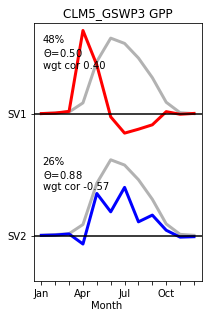

In [15]:
# Plot First and Second Singular Vectors
# TODO This is a pretty complicated plotting method that could likely be improved & made into a function
# That said, the it makes nice, clear plots... we'll keep it for now

fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
vectors2plot=vectors2*7000  #This is a totally arbitrary scale factor, 
#                            decided by me, to make figures look good!
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'r-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'b-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.50,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0])+
        "\n"+str('wgt cor %.2f' % r[0]))
ax1.text(0.5,.10,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1])+
        "\n"+str('wgt cor %.2f' % r[1]))

#ax1.text(0.5,.55,str('rank cor %.2f' % corr0))
#ax1.text(0.5,.15,str('rank cor %.2f' % corr1))

ax1.title.set_text(model[0] +' '+var[0])
ax1.text(4,-0.29,'Month')
plt.tight_layout()
plt.savefig('SVD_'+model[0]+'_ex_GPP.eps') ;


In [16]:
print(r[0])
# Can correlations between climatology and Vectors tell us someting about the nature of relationships?
# In this example SV2 shows higher correlation with climatology of GPP
x  = xr.DataArray(data=mm2plot)
y0 = xr.DataArray(data=vectors[0,:])
y1 = xr.DataArray(data=vectors[1,:])
temp = esmlab.statistics.weighted_corr(x,y1)
print(temp)
cor1 = np.corrcoef(mm2plot,vectors[0,:])
cor2 = np.corrcoef(mm2plot,vectors[1,:])
print(cor1 )
print('..')
print(cor2)

0.40061745637098467
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float32 59.842934
    lon      float32 240.0
Data variables:
    r        float64 5.836e-18
    p        float64 1.0
[[ 1.         -0.17786995]
 [-0.17786995  1.        ]]
..
[[1.         0.84945569]
 [0.84945569 1.        ]]


### How do weights from SV coorelate with seasonal climate anomalies?

[1.20287950e-06 2.96998842e-05 1.71898864e-05 7.06913715e-06]


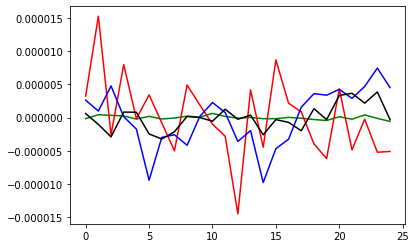

In [17]:
# TODO, there must be a better way to reshape data, but I can't get group by to work
season_group = ds_detrend_season.groupby('time.month')
#print(ds_detrend_season.GPP[0:5])
#print(ds_detrend_season.time[0:5])

#reshape timeseries vector into a matrix (season x year)
# Omits the last year, which only has data for Dec
group_0 =np.zeros([4, years])
group_1 =np.zeros([4, years])
group_2 =np.zeros([4, years])

#print(ds_detrend_season.GPP)
# Reshape timeseries vector into a matrix (season x year) 
# this could also be done with np.reshape...
for iyr in range(years):
    group_0[0:4,iyr]=ds_detrend_season.get(var[0])[(iyr*4):(iyr*4)+4] 
    group_1[0:4,iyr]=ds_detrend_season.get(var[1])[(iyr*4):(iyr*4)+4] 
    group_2[0:4,iyr]=ds_detrend_season.get(var[2])[(iyr*4):(iyr*4)+4] 

anom_range = group_0.max(axis=1)-group_0.min(axis=1)
print(anom_range)
# Plot seasonal anomalies by year
plt.plot(group_0[0,], '-',color='green')#DJF
plt.plot(group_0[1,], '-',color='red' ) #MAM
plt.plot(group_0[2,], '-',color='blue' )  #JJA
plt.plot(group_0[3,], '-',color='black' ); #SON

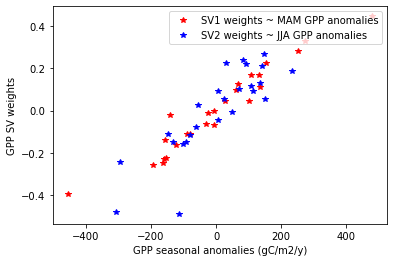

In [18]:
# in this gridcell, 
# weights for SV1 of GPP = the inverse as MAM GPP anomalies 
# weights for SV2 of GPP = the inverse as JJA GPP anomalies
s2y = 3600 * 24 * 365
plt.plot(group_0[1,:]*s2y,(weights[0,:]), '*', color='red' )
plt.plot(group_0[2,:]*s2y,(weights[1,:]), '*', color='blue' )
#plt.plot(group_0[3,:]*s2y,(weights[0,:]), '*', color='black' )
plt.xlabel(var[0]+" seasonal anomalies (gC/m2/y)")
plt.ylabel(var[0]+" SV weights")
plt.legend(loc='upper right',labels=("SV1 weights ~ MAM GPP anomalies",
                                    "SV2 weights ~ JJA GPP anomalies"));

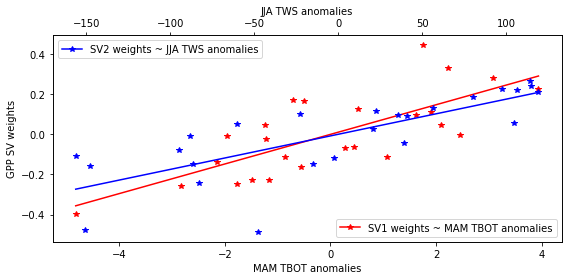

In [19]:
import matplotlib.lines as mlines
# let's reverse weights for clarity (vectors are reversed above)
x = group_1[1,:]  #MAM TBOT
y = weights[0,:]  #SV1

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)

color = 'red'
ax1.set_ylabel(var[0]+' SV weights')
ax1.set_xlabel('MAM '+var[1]+' anomalies')
ax1.plot(x, y,'*', color=color)
ax1.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=color)
red_line = mlines.Line2D([], [], color='red', marker='*',
                          label='SV1 weights ~ MAM TBOT anomalies')
ax1.legend(handles=[red_line], loc='lower right')
#ax1.title.set_text(var[0]+' SV_1 weights vs. climate')

x = group_2[2,:]  #JJA TWS
y = weights[1,:]  #SV2

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
color = 'blue'
ax2.set_xlabel('JJA '+var[2]+' anomalies')
ax2.plot(x, y,'*', color=color)
ax2.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=color)
ax2.tick_params(axis='x')
blue_line = mlines.Line2D([], [], color='blue', marker='*',
                          label='SV2 weights ~ JJA TWS anomalies')
ax2.legend(handles=[blue_line], loc='upper left')

fig.tight_layout();
#plt.plot(group_1[1,:],(weights[0,:]), '*', color='blue' )
#plt.plot(group_1[2,:],(weights[1,:]), '*', color='red' )
#plt.xlabel(var[0]+" seasonal anomalies (gC/m2/s)")
#plt.ylabel(var[0]+" SV weights")
#plt.legend(loc='upper right',labels=("SV1 weights ~ MAM GPP anomalies",
#                                     "SV2 weights ~ JJA GPP anomalies"));

In [20]:
# --- Correlations with climate anomalies ---
print('weight correlations with seasonal anomalies')
for i in range(4):
    print(corr(weights[0,:],group_0[i,:],np.ones(years))*anom_range[i])

r0a = corr(weights[0,:],group_1[1,:],np.ones(years))
r1a = corr(weights[0,:],group_2[1,:],np.ones(years))
r0b = corr(weights[0,:],group_1[2,:],np.ones(years))
r1b = corr(weights[0,:],group_2[2,:],np.ones(years))
r0c = corr(weights[0,:],group_1[3,:],np.ones(years))
r1c = corr(weights[0,:],group_2[3,:],np.ones(years))

r2a = corr(weights[1,:],group_1[1,:],np.ones(years))
r3a = corr(weights[1,:],group_2[1,:],np.ones(years))
r2b = corr(weights[1,:],group_1[2,:],np.ones(years))
r3b = corr(weights[1,:],group_2[2,:],np.ones(years))
r2c = corr(weights[1,:],group_1[3,:],np.ones(years))
r3c = corr(weights[1,:],group_2[3,:],np.ones(years))

print()
print(var[0]+' SV_1, '+var[1]+' MAM anom. : %.3f' % r0a)
print(var[0]+' SV_1, '+var[2]+' MAM anom. : %.3f' % r1a)
print(var[0]+' SV_1, '+var[1]+' JJA anom. : %.3f' % r0b)
print(var[0]+' SV_1, '+var[2]+' JJA anom. : %.3f' % r1b)
print(var[0]+' SV_1, '+var[1]+' SON anom. : %.3f' % r0c)
print(var[0]+' SV_1, '+var[2]+' SON anom. : %.3f' % r1c)
print()
print(var[0]+' SV_2, '+var[1]+' MAM anom. : %.3f' % r2a)
print(var[0]+' SV_2, '+var[2]+' MAM anom. : %.3f' % r3a)
print(var[0]+' SV_2, '+var[1]+' JJA anom. : %.3f' % r2b)
print(var[0]+' SV_2, '+var[2]+' JJA anom. : %.3f' % r3b)
print(var[0]+' SV_2, '+var[1]+' SON anom. : %.3f' % r2c)
print(var[0]+' SV_2, '+var[2]+' SON anom. : %.3f' % r3c)

# once we arrange the vectors correctlym
# phase shift (SV1),  + correlated with MAM TBOT anomalies, - correlated with SON TWS
# amplification(SV2), + correlated with JJA TWS anomalies
# this pattern of Phase ~ TBOT & Amp ~ TWS holds for CLM4.5 too

weight correlations with seasonal anomalies
5.22218144585726e-07
2.8650247669605638e-05
-6.1702278200015724e-06
-1.2696827095670313e-06

GPP SV_1, TBOT MAM anom. : 0.746
GPP SV_1, TWS MAM anom. : -0.230
GPP SV_1, TBOT JJA anom. : -0.056
GPP SV_1, TWS JJA anom. : -0.245
GPP SV_1, TBOT SON anom. : -0.061
GPP SV_1, TWS SON anom. : -0.208

GPP SV_2, TBOT MAM anom. : 0.302
GPP SV_2, TWS MAM anom. : 0.703
GPP SV_2, TBOT JJA anom. : 0.080
GPP SV_2, TWS JJA anom. : 0.770
GPP SV_2, TBOT SON anom. : -0.174
GPP SV_2, TWS SON anom. : 0.793


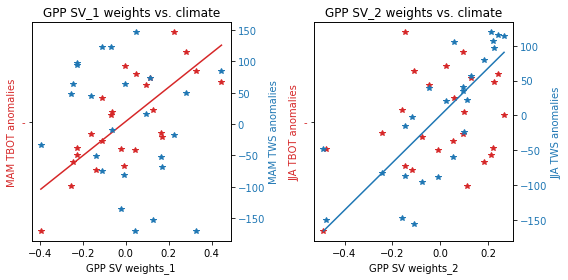

In [21]:
# -- plot SV_1, w/ regression for JJA TBOT anomalies --
x = weights[0,:]
y = group_1[1,:]
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(1,2,1)
color = 'tab:red'
ax1.set_xlabel(var[0]+' SV weights_1')
ax1.set_ylabel('MAM '+var[1]+' anomalies', color=color)
ax1.plot(x, y,'*', '-', color=color)
ax1.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text(var[0]+' SV_1 weights vs. climate')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('MAM '+var[2]+' anomalies', color=color)
ax2.plot(x, group_2[1,:],'*' , color=color)
ax2.tick_params(axis='y', labelcolor=color)

# --- now sv_2, w/ regression for TWS
ax3 = fig.add_subplot(1,2,2)
x = weights[1,:]
y = group_2[2,:]
color = 'tab:red'
ax3.set_xlabel(var[0]+' SV weights_2')
ax3.set_ylabel('JJA '+var[1]+' anomalies', color=color)
ax3.plot(x, group_1[1,:],'*', '-', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.title.set_text(var[0]+' SV_2 weights vs. climate')

ax4 = ax3.twinx()  
color = 'tab:blue'
ax4.set_ylabel('JJA '+var[2]+' anomalies', color=color)
ax4.plot(x, y,'*' , color=color)
ax4.tick_params(axis='y', labelcolor=color)
ax4.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=color)
fig.tight_layout();

### End of example code  

# ------ Global SVD ------
* Calculate climatology & anomalies, then
* Detrend data & reshape for SVD & finally
* Identify amplification vs. early onset vectors

#### TODO, in the global code we'll need to: 
* Determine how SV weights correspond with GPP anomalies (+ or -)

In [22]:
# Use esmlab to calculate climatology & anomalies
# TODO, refer to variables by name (e.g. anom_gpp) to improve readability
# Will leave this for now to have a more generalizable code

ds2 = ds.isel(time=slice(-months,None))             # Select last N years of data
ds_climo = esmlab.core.climatology(ds2,freq='mon')  # Calculate climatology
ds_anom  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
ds_anom  = ds_anom.where(ds_anom.get(var[0]).max(dim='time'))  # mask out regions with no GPP for all variables

#### Define wrapper function that includes: 
- Detrending, reshaping, SVD & 
- Returns a np.array with vectors, weights, theta & varfrac
- We dont' need the SV for TBOT and TWS, but we do need seasonal means of detrended anomalies 

In [23]:
# define function to cacluate svd vectors, weights, etc.
# First we have to detrend the data
def svd_wrap(anom, years=years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (months x year) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac, vectors, weights

In [24]:
## Select a single grid point to work with first
## Make sure wrapper results are the same as above
#[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(ds_temp.get(var[0]).values, years)
#plt.plot(theta_wrap - theta, '*') ;
#plt.plot(varfrac_wrap - varfrac, '*',c='r') ;
#print ('differences between results look prety small')

#### Make frunction to Loop through each grid cell & dataset to save output
- Would Dask make this faster?
- how do we also mask non-veg land cells?


In [25]:
# TODO, this is the time consuming bit of the code.
# JH recommends using map_blocks, once it's developed farther
def calc_svd(da, nyears=years):
    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    # setup output variables
    # number of vectors in svd = nyears
    theta_shape = yx_shape + (nyears, )
    vector_shape = yx_shape + (nyears, 12)
    weights_shape = yx_shape + (nyears, nyears)
    out = xr.Dataset( coords={"lat": da.lat, "lon": da.lon, 'sv': range(nyears) } )

    varnames = ['theta', 'varfrac', 'vectors', 'weights']
    out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'sv'))
    out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'sv'))
    out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('lat', 'lon', 'sv', 'time'))
    out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('lat', 'lon', 'sv', 'year'))
    # For clarity, rename dimensions of weights (dim1 = vector#, dim2 = year)
    #                                   vectors (dim1 = vector#, dim2 = month)
    for (i, j), mask in np.ndenumerate(da.isel(time=0).isnull()):
        if not mask:
            return_vals = svd_wrap(da.isel(lat=i, lon=j).data)

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    return out

In [26]:
%%time
# TODO, again more descriptive names will make the code easier to read, but for now keeping general 
# e.g. svd_gpp = calc_svd(ds_anom['GPP'])
da0 = ds_anom.get(var[0])  
svd0 = calc_svd(da0)  # GPP 
print('finished svd0, '+var[0])

# JH, When I loaded the data as you suggested in cell #2-3, a bunch of warnings crop up.  
# Reading the data less effiently doesn't generate the errors (as curently implimented), 
# and also seems to make the loop work more efficiently.

finished svd0, GPP
CPU times: user 2min 58s, sys: 112 ms, total: 2min 58s
Wall time: 2min 58s


In [27]:
# rearrange output & write out to scratch
def transpose(da_in, var):
    out = da_in
    out['theta']   = out.theta.transpose('sv','lat','lon')
    out['varfrac'] = out.varfrac.transpose('sv','lat','lon')
    out['vectors'] = out.vectors.transpose('sv', 'time','lat','lon') 
    out['weights'] = out.weights.transpose('sv', 'year','lat','lon')
    ds_climo['time'] = out.time  # get time coords to match
    out['climatology'] = ds_climo.get(var)
    out.to_netcdf(path='/glade/scratch/wwieder/svd/'+model[0]+'_svd_'+var+'.nc')  
    return out

#this could also be more specific for readability, using 'GPP' instead of var[0]
svd0 = transpose(svd0, var[0])   

## --- Correlations between vectors and climatology of GPP ---
Example from http://xarray.pydata.org/en/stable/dask.html

In [28]:
import bottleneck
# also try weighting correlation based on monthly contribution to annual flux
# This is code that's likely better suited for a 3rd partly library like esmlab
# TODO, file issue with requst for these kinds of statistical functions to esmlab?

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def pearson_correlation(x, y, dim):
    return xr.apply_ufunc(
        pearson_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

# Weighted coorelation
def covariance_gufunc_wgt(x, y, w):
    return ((w * x - (x*w).mean(axis=-1, keepdims=True))
            * (y - (y*w).mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc_wgt(x, y, w):
    return covariance_gufunc_wgt(x, y, w) / np.sqrt(
        covariance_gufunc_wgt(x, x, w) * covariance_gufunc_wgt(y,y,w))

def pearson_correlation_wgt(x, y, w, dim):
    return xr.apply_ufunc(
        pearson_correlation_gufunc_wgt, x, y, w,
        input_core_dims=[[dim], [dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

# rank correlation
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

(12, 192, 288)


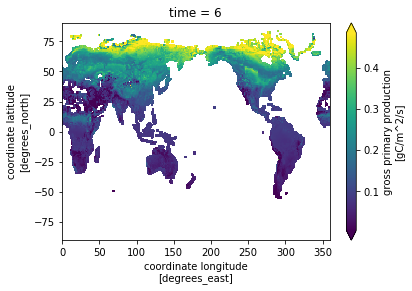

In [29]:
# Pull off climatology of GPP & calculate weights based on annual cycle
GPPclimo = ds_climo.GPP
GPPwgt   = GPPclimo / GPPclimo.sum(dim='time') 
print(GPPwgt.shape)
GPPwgt.isel(time=6).plot(robust=True); 

In [30]:
# subset data arrays for processing & shape correctly
print(svd0.vectors.isel(sv=0).shape)
GPPvector_0 = svd0.vectors.isel(sv=0)
GPPvector_1 = svd0.vectors.isel(sv=1)
GPPclimo['time'] =  GPPvector_0['time'] = svd0.time  # get time coords to match
GPPclimo['time'] = svd0.time  # get time coords to match
#GPPvector_0[6,:,:].plot(robust=True);

(12, 192, 288)


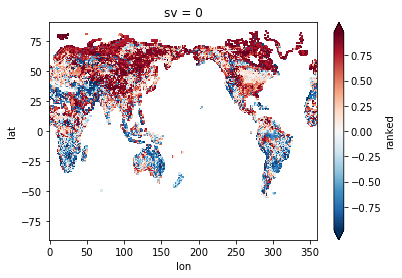

In [41]:
# now calculate the correlations, GPP vectors w/ GPP climatology
# pearson, weighted, and ranked correlations
dims = dict(zip(ds.GPP.dims, ds.GPP.shape))
yx_shape = (dims['lat'], dims['lon'])
# setup output variables
# number of vectors in svd = nyears
corr_shape = (years, ) + yx_shape 
    
GPP_corr = xr.Dataset( coords={'sv': range(years) , "lat": ds.lat, "lon": ds.lon} )
GPP_corr['pearson'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
GPP_corr['weighted'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
GPP_corr['ranked'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))

for i in range(years):
    temp_vector = svd0.vectors.isel(sv=i)
    GPP_corr.pearson[i,...] = pearson_correlation(GPPclimo, temp_vector, 'time')
    GPP_corr.weighted[i,...] = pearson_correlation_wgt(GPPclimo, temp_vector, GPPwgt,'time')
    GPP_corr.ranked[i,...] = spearman_correlation(GPPclimo, temp_vector, 'time')

GPP_corr.ranked[0,:,:].plot(robust=True);

### Make plots to visualize results

In [32]:
import matplotlib.colors as colors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

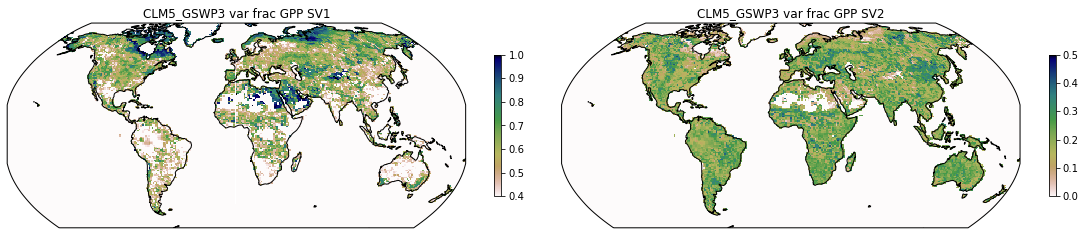

In [33]:
# just look at fraction of variance explained for each vector
# TODO is there some meaningful way to visualize information on the magnitude of each vector 
# regionally or among models?, maybe this is with the regional plots, or as a zonal mean plot?
vmax = 1.
vmin = 0.4
lat = svd0.lat.values
lon = svd0.lon.values
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(lon,lat,svd0.varfrac.values[0,:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.1,label='')
ax1.coastlines()
ax1.set_title(model[0]+' var frac '+var[0]+' SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

vmax = 0.5
vmin = 0.
ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(lon,lat,svd0.varfrac.values[1,:,:],
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.1,label='')
ax2.coastlines()
ax2.set_title(model[0]+' var frac '+var[0]+' SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout();

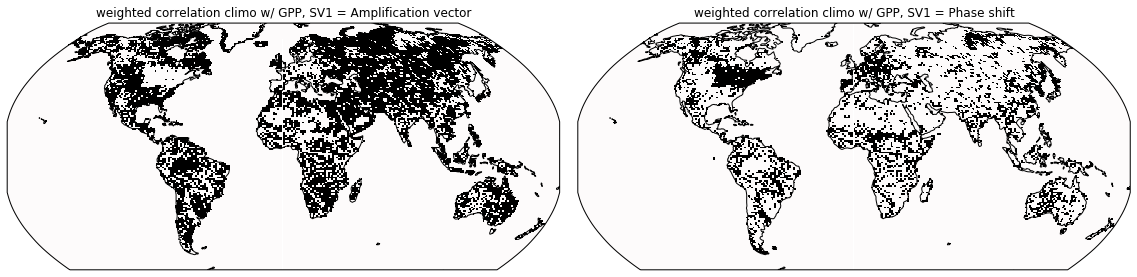

In [100]:
# Mask values to isolate regions with amplificaiton vs. phase shift (early green-up)?
# here using rank correlation, but also could use weighted 
GPP_climo_mask1 = xr.ufuncs.fabs(GPP_corr.ranked[0,...]) >= xr.ufuncs.fabs(GPP_corr.ranked[1,...])  
GPP_climo_mask2 = xr.ufuncs.fabs(GPP_corr.ranked[1,...]) > xr.ufuncs.fabs(GPP_corr.ranked[0,...])  
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(lon,lat,GPP_climo_mask1.values[:,:], 
                     transform=ccrs.PlateCarree(),
                     vmax=vmax,vmin=vmin,cmap='gist_earth_r')
#fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('weighted correlation climo w/ GPP, SV1 = Amplification vector')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(lon,lat,GPP_climo_mask2.values[:,:],
                     transform=ccrs.PlateCarree(),
                     vmax=vmax,vmin=vmin,cmap='gist_earth_r')
#fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('weighted correlation climo w/ GPP, SV1 = Phase shift')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree());
fig.tight_layout();

#### Phase shift mainly in agricutrulal regions & temperate decid. forest!

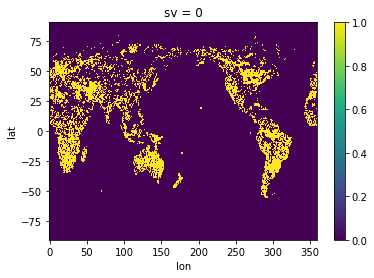

In [101]:
flip_corr = 0+(GPP_corr.weighted < -0.25)
flip_corr[0,:,:] = flip_corr[0,:,:].where(GPP_climo_mask1, 0) #only reverse amplitude vectors where needed
flip_corr[1,:,:] = flip_corr[1,:,:].where(GPP_climo_mask2, 0)

# Still need a better way to think about flipping early phase vectors where needed...
max_vector = svd0.vectors.argmax(dim='time') 
min_vector = svd0.vectors.argmin(dim='time') 
flip_vector = 0+(min_vector < max_vector)
flip_vector[0,:,:] = flip_vector[0,:,:].where(GPP_climo_mask2,0)
flip_vector[1,:,:] = flip_vector[1,:,:].where(GPP_climo_mask1,0)

flip_combined = flip_corr + flip_vector #+  
flip_combined.isel(sv=0).plot()


svd2 = svd0.copy(deep=True) ## create new datasets that don't change the orig. results
for i in range(years):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(flip_combined[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(flip_combined[i,...] <= 0, -1*svd2.weights[i,...])

#### This seems to work for amplitude vectors
#### Still need a better way to think about flipping early phase vectors where needed...

In [222]:
# calculate mean annual cycle and mean SV1 and SV2 for different regions
# TODO, This may be more efficient in a loop with different lists of lat-lon regions to focus on.

a = -30  # Min lat, -20 to 10 for Amazon
b = 0  # Max lat
c = 0   # min lon, 280-310 for the Amazon
d = 360 # max lon 
svd_plot = svd2
mean_svd_plot = svd_plot.sel(lat=slice(a,b), lon=slice(c,d)).mean(('lat','lon')) 

# -- Amplitude vector --
mean_svd_plotA = svd_plot.where(GPP_climo_mask1).sel(lat=slice(a,b), lon=slice(c,d)).mean(('lat','lon')) 
# -- Phase shift vector -- 
mean_svd_plotB = svd_plot.where(GPP_climo_mask2).sel(lat=slice(a,b), lon=slice(c,d)).mean(('lat','lon')) 
#print(mean_svd_plot)

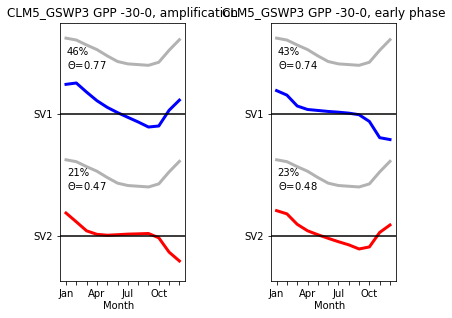

In [223]:
# Plot First and Second Singular Vectors
# TODO, but this plotting routine into a function

fig = plt.figure(4,figsize=(6,4.5))
barwidth = 0.2
month = np.arange(12)
multi =0.7e4        #This is a totally arbitrary scale factor, decided by me, to make figures look good!
ymax=np.max(mean_svd_plotA.vectors.values)

# --- GPPP, SVD 1 & 2 for regions in phase with GPP 
vectors2plot=mean_svd_plotA.vectors*multi  
mm2plot = mean_svd_plot.climatology

ax1 = fig.add_subplot(1,2,1)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])

ax1.text(0.5,.50,str(int(mean_svd_plotA.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotA.theta[0]))
ax1.text(0.5,.10,str(int(mean_svd_plotA.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotA.theta[1]))
ax1.title.set_text(model[0]+" "+var[0]+" "+str(a)+"-"+str(b)+", amplification")
ax1.text(4,-0.29,'Month')

vectors2plot=mean_svd_plotB.vectors*multi  
mm2plot = mean_svd_plot.climatology
ax2 = fig.add_subplot(1,2,2)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax2.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax2.axhline(-0.05,color='black')
ax2.axhline(0.35,color='black')
ax2.set_xticks(np.array(month)+2*barwidth)
ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax2.set_yticks([-0.05,0.35])
ax2.set_yticklabels(['SV2','SV1'])
ax2.set_ylim([-0.2,0.65])

ax2.text(0.5,.50,str(int(mean_svd_plotB.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotB.theta[0]))
ax2.text(0.5,.10,str(int(mean_svd_plotB.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotB.theta[1]))
ax2.title.set_text(model[0]+" "+var[0]+" "+str(a)+"-"+str(b)+", early phase")
ax2.text(4,-0.29,'Month')

plt.tight_layout();

### Seems to:
* Appropriately identify SV1 as amplification or early phase vectors
* SV1 explians most of varriation (at least for high & mid latitudes)
* SV2 of phase shift = amplificaiton!
* maybe additional work needed for tropics?

In [224]:
# try flipping weights & vectors for early phase (at leat in NH)


# ----- Correlate SV weights w/ seasonal anomalies -----
* Claculate seasonal means of detrended data
* Reshape anomaly vectors to season x year array
* Correlate GPP SV1 weights w/ seasonal GPP anomalies & 
* Reverse / flip weights where needed
* Calculate correlation for GPP SV1 weights w/ seaonal climate anomalies

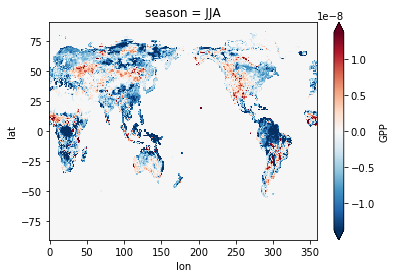

In [225]:
def dtrend(anom, dim):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(signal.detrend, anom,
                       input_core_dims=[[dim]],
                       output_core_dims=[[dim]],
                       kwargs={'axis': -1})


# Build datastet to hold results
dims = dict(zip(ds_anom.get('GPP').dims, ds_anom.get('GPP').shape))
out_shape = (dims['lat'], dims['lon'], 4, years)
seasonID = xr.DataArray([12,3,6,9], dims='season') # seasonal time slices
seasonName = xr.DataArray(['DJF','MAM','JJA','SON'], dims='season') # can coords be a string?
yearID   = xr.DataArray(np.unique(ds_anom.time['time.year']), dims='year')
dt_anom  = xr.Dataset( coords={"lat": ds_anom.lat, "lon": ds_anom.lon, 
                               "season": seasonName, "year": yearID} )

for v in range(len(var)):
    dt_anom[var[v]] = xr.DataArray(np.zeros(out_shape), dims=('lat', 'lon','season','year'))
    

    dt = dtrend(ds_anom.get(var[v]).load().fillna(0), 'time')
    dt_season = dt.resample(time="QS-DEC").mean().isel(time=slice(0,-1))

    # now reshape
    for m in range(len(seasonID)):
        temp = dt_season.where(dt_season.time['time.month']==seasonID[m], drop=True)
        dt_anom[var[v]][:,:,m,:] = temp


dt_anom = dt_anom.transpose('season','year','lat','lon')
dt_anom.GPP.isel(season=2).mean(dim='year').plot(robust=True);

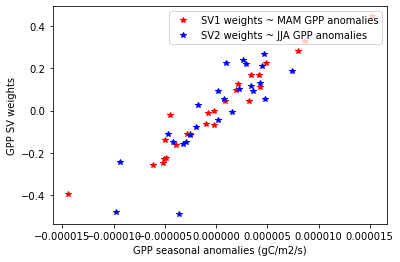

In [226]:
# Results look at example from single grid cell, with 
# GPP_sv weights ~ seasonal anomalies 
# sv1 Early shift = spring & sv2 Amplificaton = summer

plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=1),
         svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='red')
plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=2),
         svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='blue')
plt.xlabel(var[0]+" seasonal anomalies (gC/m2/s)")
plt.ylabel(var[0]+" SV weights")
plt.legend(loc='upper right',labels=("SV1 weights ~ MAM GPP anomalies",
                                     "SV2 weights ~ JJA GPP anomalies"));

#### Weights typically have have the same sign as GPP anomalies
* But not always in tropics
* Do we need to reverse vectors and weights where this negative correlation exists?
* We'll try this in a bit

### Now look for correlations for GPP sv weights & GPP anomalies
* this will be used to flip weights for sv1 as needed

In [227]:
# Write out correlation matrix for weights of GPP SV with detrended anomalies 
# Loop over each SV (2), variable (3), & season (4)

def corr_wrap(anom, svd):
    da = anom.to_array() 
    dims = dict(zip(da.dims, da.shape))
    corr_shape = (2,dims['season'], dims['lat'], dims['lon'])

    # setup output variables
    corr = xr.Dataset( coords={'sv': range(2), 'season':seasonName, 
                               "lat": ds.lat, "lon": ds.lon} )

    for v in range(len(var)):     # variables
        corr[var[v]] = xr.DataArray(np.zeros(corr_shape), dims=('sv','season','lat', 'lon'))

        # loop through to calculate correlation coef.
        for i in range(2):         # vectors
            for j in range(len(seasonName)): # seasons
                return_vals = pearson_correlation(anom.get(var[v]).isel(season=j), 
                                                  svd['weights'].isel(sv=i), 'year')
                corr[var[v]][i,j,...] = return_vals
        
    return corr

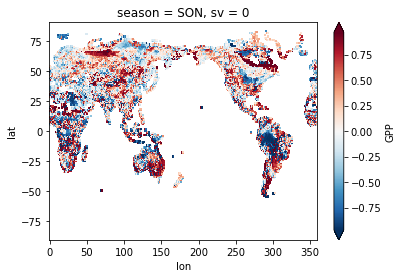

In [228]:
# Create correlation matrix
# first make year dimensions indential
svd0['year'] = dt_anom.get('year')
svd2['year'] = dt_anom.get('year')
svd0_corr = corr_wrap(dt_anom, svd0)
svd2_corr = corr_wrap(dt_anom, svd2)

# --- Check that results ar sensible ---
# GPP SV1 coorelated with JJA GPP anomalies in NH, as expected
# GPP SV1 coorelated with MAM GPP anomalies in early shift regions (NE USA + Ag.) 
svd2_corr['GPP'].isel(sv=0, season=3).plot(robust=True);

Weights do not necessarily have the same sign as GPP anomalies
(e.g. see single grid example above)
- Itentify season with maximum abs(correlation) between SV weights & GPP anomalies
- Reverse vectors and weights where this value < 0
- repeat correlation matrix

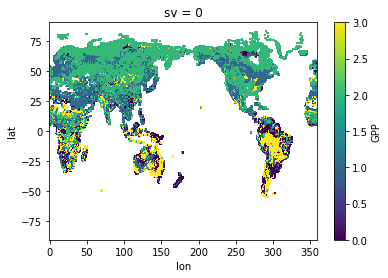

In [229]:
# xr.ufuncs.fabs calculates the absolute value for an xarray object
# argmax picks the index of the largest value across a dimension.

gppMask = svd0_corr['GPP'].max(dim='season')
maxGPP_season = xr.ufuncs.fabs(svd0_corr['GPP'].fillna(-1)).argmax(dim='season').where(gppMask.notnull())
maxGPP_season.isel(sv=0).plot(robust=True);

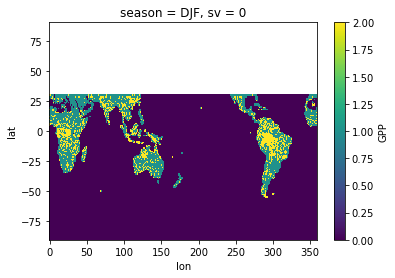

In [231]:
# Want to flip weights and vectors when sv_corr['GPP'] < 0 in the maxSeason
# Where sv_corr[gpp] of season[j] < 0  & 
#       maxGPP = season[j] 
#   Flip sign of weights and vectors
# this is really ugly but sees to do the right thing

# 1) Identify all land points with a value of 1
flipper = 0+(svd0_corr['GPP'].isel(season=0) < 2)

# 2) loop through vectors and Seasons
for i in range(2):         # vectors
    for j in range(len(seasonName)): # seasons

        temp = maxGPP_season.isel(sv=i) == j
        temp2 = svd2_corr['GPP'].isel(sv=i, season=j).where(temp)
        temp3 = 0+(temp2 < 0) #so mask is true where corr > 0
        # 3) Add 1 when maxSeason anomalies has negative correlation with GPP weights
        flipper[i,...] = flipper[i,...] + temp3
        #if j == 1 & i == 1:
            #temp.plot(robust=True);

# 4) all grids with flipper = 2 need vectors and weights flipped for SV1
#flipper=flipper.where(GPP_climo_mask1)
flipper = flipper.where(flipper.lat<30)
flipper.isel(sv=0).plot(robust=True);


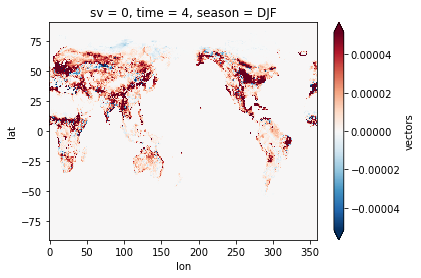

In [232]:
# now flip vectors and weights for identified grids (flipper>1)
svd_new = svd2.copy(deep=True)
svd_new['weights'] = xr.where(flipper.isel(sv=slice(0,2))==2, 
                              -1*svd_new['weights'].isel(sv=slice(0,2)),
                             svd_new['weights'].isel(sv=slice(0,2)))
svd_new['vectors'] = xr.where(flipper.isel(sv=slice(0,2))==2, 
                              -1*svd_new['vectors'].isel(sv=slice(0,2)),
                             svd_new['vectors'].isel(sv=slice(0,2)))
#svd_new['vectors']= svd_new['vectors'].isel(sv=slice(0,2)).where(flipper.isel(sv=slice(0,2))>1, 
#                                                        -1*svd_new['vectors'].isel(sv=slice(0,2)))
svd_new.vectors.isel(time=4, sv=0).plot(robust=True);
#print(svd0['weights'].isel(sv=slice(0,2)))

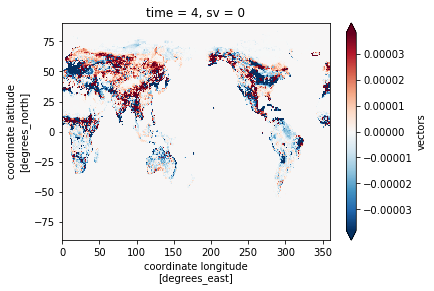

In [233]:
svd0.vectors.isel(time=4, sv=0).plot(robust=True);

## ------ Now look at plots and correlations again ------

In [263]:
# calculate mean annual cycle and mean SV1 and SV2 for different regions
# TODO, This may be more efficient in a loop with different lists of lat-lon regions to focus on.

a = 0  # Min lat, -20 to 10 for Amazon
b = 30  # Max lat
c = 0   # min lon, 280-310 for the Amazon
d = 360 # max lon 
svd_plot = svd_new
mean_svd_plot = svd_plot.sel(lat=slice(a,b), lon=slice(c,d)).mean(('lat','lon')) 

# -- Amplitude & phase shift vectors --
mean_svd_plotA = svd_plot.where(GPP_climo_mask1).sel(lat=slice(a,b), lon=slice(c,d)).mean(('lat','lon')) 
mean_svd_plotB = svd_plot.where(GPP_climo_mask2).sel(lat=slice(a,b), lon=slice(c,d)).mean(('lat','lon')) 


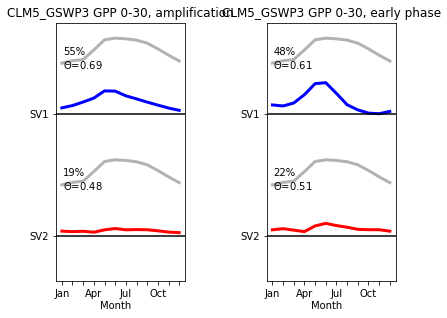

In [264]:
# Plot First and Second Singular Vectors
# TODO, but this plotting routine into a function

fig = plt.figure(4,figsize=(6,4.5))
barwidth = 0.2
month = np.arange(12)
multi =0.7e4        #This is a totally arbitrary scale factor, decided by me, to make figures look good!
ymax=np.max(mean_svd_plotA.vectors.values)

# --- GPPP, SVD 1 & 2 for regions in phase with GPP 
vectors2plot=mean_svd_plotA.vectors*multi  
mm2plot = mean_svd_plot.climatology

ax1 = fig.add_subplot(1,2,1)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])

ax1.text(0.5,.50,str(int(mean_svd_plotA.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotA.theta[0]))
ax1.text(0.5,.10,str(int(mean_svd_plotA.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotA.theta[1]))
ax1.title.set_text(model[0]+" "+var[0]+" "+str(a)+"-"+str(b)+", amplification")
ax1.text(4,-0.29,'Month')

vectors2plot=mean_svd_plotB.vectors*multi  
mm2plot = mean_svd_plot.climatology
ax2 = fig.add_subplot(1,2,2)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax2.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax2.axhline(-0.05,color='black')
ax2.axhline(0.35,color='black')
ax2.set_xticks(np.array(month)+2*barwidth)
ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax2.set_yticks([-0.05,0.35])
ax2.set_yticklabels(['SV2','SV1'])
ax2.set_ylim([-0.2,0.65])

ax2.text(0.5,.50,str(int(mean_svd_plotB.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotB.theta[0]))
ax2.text(0.5,.10,str(int(mean_svd_plotB.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%mean_svd_plotB.theta[1]))
ax2.title.set_text(model[0]+" "+var[0]+" "+str(a)+"-"+str(b)+", early phase")
ax2.text(4,-0.29,'Month')

plt.tight_layout();

## Now repeat correlation matrix calculations

In [259]:
svd_new_corr = corr_wrap(dt_anom, svd_new)

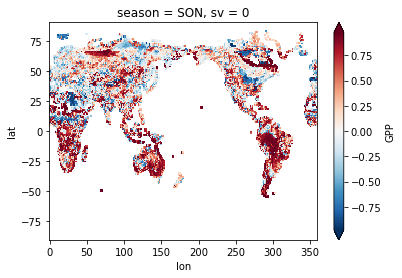

In [266]:
svd_new_corr.GPP.isel(sv=0,season=3).plot(robust=True);

### Next should look at environmental correlations in dominant seasons
cor. svd[weights] ~ TBOT and TWS anomalies


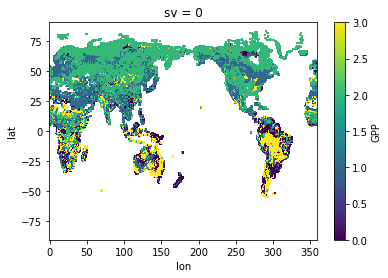

In [265]:
maxGPP_season.isel(sv=0).plot(robust=True);

In [ ]:
# GPP SV_1 coorelated with MAM GPP anomalies in early shift regions (NE USA + Ag.)
sv_corr['coef'].isel(sv=0,var=1, season=0).where(GPP_climo_mask2).plot(robust=True);

### Grids characterized by early phase GPP SV1 also have higher % varriation explianted by soil water SV

In [ ]:
# create arrays for amplification and early phase vectors
# the other line of code selects when SV2 characterizes the same shape vector
ampGPPvectors = svd0.vectors.sel(vectors_dim1=0).where(GPP_climo_mask1)
#                                                       other= svd0.vectors.sel(vectors_dim1=1))
phaseGPPvectors = svd0.vectors.sel(vectors_dim1=0).where(GPP_climo_mask2)
#                                                         other = svd0.vectors.sel(vectors_dim1=1))
  
# Weighted correlation between amplification vs. early phase vectors & climate, 
ampGPP_TBOT_0 = pearson_correlation_wgt(ampGPPvectors, TBOTvector_0,GPPwgt,'time') 
ampGPP_TBOT_1 = pearson_correlation_wgt(ampGPPvectors, TBOTvector_1,GPPwgt,'time')
ampGPP_SMOI_0 = pearson_correlation_wgt(ampGPPvectors, SMOIvector_0,GPPwgt,'time')
ampGPP_SMOI_1 = pearson_correlation_wgt(ampGPPvectors, SMOIvector_1,GPPwgt,'time')
ampGPP_TBOT_0.name ='ampGPP_TBOT_0'  # Provide name for variable to join dataset
ampGPP_TBOT_1.name ='ampGPP_TBOT_1'
ampGPP_SMOI_0.name ='ampGPP_SMOI_0'
ampGPP_SMOI_1.name ='ampGPP_SMOI_1'

phaseGPP_TBOT_0 = pearson_correlation_wgt(phaseGPPvectors, TBOTvector_0,GPPwgt,'time')
phaseGPP_TBOT_1 = pearson_correlation_wgt(phaseGPPvectors, TBOTvector_1,GPPwgt,'time')
phaseGPP_SMOI_0 = pearson_correlation_wgt(phaseGPPvectors, SMOIvector_0,GPPwgt,'time')
phaseGPP_SMOI_1 = pearson_correlation_wgt(phaseGPPvectors, SMOIvector_1,GPPwgt,'time')
phaseGPP_TBOT_0.name ='phaseGPP_TBOT_0'
phaseGPP_TBOT_1.name ='phaseGPP_TBOT_1'
phaseGPP_SMOI_0.name ='phaseGPP_SMOI_0'
phaseGPP_SMOI_1.name ='phaseGPP_SMOI_1'

In [ ]:
# plot correlations with soil moisture & Temp
# this is for grid cells with SV1 showing amplification signial
# in cell above using the 'other' filter would allow us to look at all grid cells
# For clarity, it may be best to just show single plot with max correlations (Temp vs. Moisture)
ampGPP = xr.concat([ampGPP_SMOI_0,ampGPP_SMOI_1,ampGPP_TBOT_1,ampGPP_TBOT_0], dim='correlation')
#print(ampGPP)
phaseGPP = xr.concat([phaseGPP_SMOI_0,phaseGPP_SMOI_1,phaseGPP_TBOT_1,phaseGPP_TBOT_0], dim='correlation')
#print(ampGPP)

# argmax picks the index of the largest value across a dimension.
# 0 & 1 = soil moisture SV 1 & 2
# 2 & 3 = temperature SV 2 & 1
# The use of this mask seem to modify the look of plots, this one seems best
ampMask = ampGPP[1,:,:]
phaseMask = phaseGPP[1,:,:]

maxAmpGPP = xr.ufuncs.fabs(ampGPP).fillna(-1).argmax(dim='correlation').where(ampMask.notnull())
maxPhaseGPP = xr.ufuncs.fabs(phaseGPP).fillna(-1).argmax(dim='correlation').where(phaseMask.notnull())
#maxPhaseGPP.plot(robust=True);


In [ ]:
# vmax here just set to visually provide 
# red (temp) vs. blue (moisture) corrleations 

fig = plt.figure(figsize=(16,20))
ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(lon,lat,maxAmpGPP,
                     transform=ccrs.PlateCarree(),vmax=3,vmin=0,cmap='bwr')
#fig.colorbar(im1,ax=ax1,shrink=0.01,label='')
ax1.coastlines()
ax1.set_title('Amplification correlation')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(lon,lat,maxPhaseGPP,
                     transform=ccrs.PlateCarree(),vmax=3,vmin=0,cmap='bwr')
#fig.colorbar(im2,ax=ax2,shrink=0.01,label='')
ax2.coastlines()
ax2.set_title('Phase shift correlations')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout();
print(maxAmpGPP.mean())
print(maxPhaseGPP.mean())

In [ ]:
# plot correlations with soil moisture & Temp
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(2,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(lon,lat,xr.ufuncs.fabs(phaseGPP_SMOI_0),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.17,label='')
ax1.coastlines()
ax1.set_title('Weighted correlation phaseGPP w/ Moisture SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(2,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(lon,lat,xr.ufuncs.fabs(phaseGPP_SMOI_1),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.17,label='')
ax2.coastlines()
ax2.set_title('Weighted correlation phaseGPP w/ Moisture SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()

ax3 = fig.add_subplot(2,2,3,projection=ccrs.Robinson())
im3 = ax3.pcolormesh(lon,lat,xr.ufuncs.fabs(phaseGPP_TBOT_0),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im3,ax=ax3,shrink=0.17,label='')
ax3.coastlines()
ax3.set_title('Weighted correlation phaseGPP w/ TBOT SV1')
ax3.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(2,2,4,projection=ccrs.Robinson())
im4 = ax4.pcolormesh(lon,lat,xr.ufuncs.fabs(phaseGPP_TBOT_1),
                     transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im4,ax=ax4,shrink=0.17,label='')
ax4.coastlines()
ax4.set_title('Weighted correlation phaseGPP w/ TBOT SV2')
ax4.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()

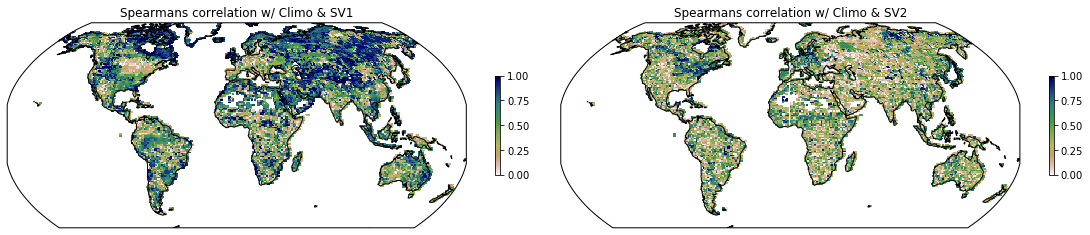

In [38]:
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(GPPr_0.lon.values,GPPr_0.lat.values,xr.ufuncs.fabs(GPPr_0),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('Spearmans correlation w/ Climo & SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(GPPr_1.lon.values,GPPr_1.lat.values,xr.ufuncs.fabs(GPPr_1),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('Spearmans correlation w/ Climo & SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()



TypeError: Dimensions of C (25, 192) are incompatible with X (288) and/or Y (192); see help(pcolormesh)

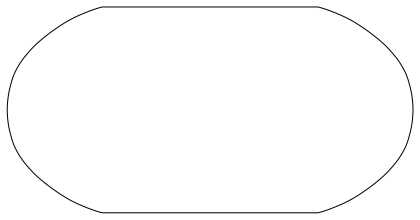

In [39]:
vmax = 1.
vmin = 0.
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(svd2.lon.values,svd2.lat.values,svd0.theta.values[:,:,0],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('$\Theta$ SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(svd2.lon.values,svd2.lat.values,svd0.theta.values[:,:,1],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('$\Theta$ SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()


<Figure size 360x252 with 0 Axes>

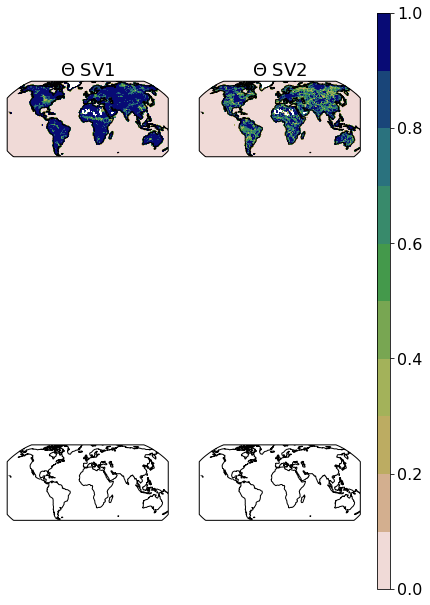

In [72]:
lat = svd2.coords['lat']
lon = svd2.coords['lon']
x0 = svd0.theta[:,:,0]
x1 = svd0.theta[:,:,1]

norm = colors.Normalize(vmin=0, vmax=1.)

# modified from https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
crs = ccrs.Robinson()#central_longitude=305.0)

# Function used to create the map subplots
def plot_background(ax):
    ax.set_global()
    ax.coastlines()
    #ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

levels = np.linspace(0, 1, 11)
fig = plt.figure(figsize=(5, 3.5),constrained_layout=True);
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(6, 10), constrained_layout=True,
                          subplot_kw={'projection': crs})

axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
    ax.set_extent([-155, 60, -25, 60])  # I really don't understand how this works??
#    ax.set_extent([-150, 60, -25, 60])


# upper plot
cf0 = axlist[0].contourf(lon, lat, x0, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[0].set_title('$\Theta$ SV1', fontsize=18)
axlist[0].set_axis_off()

# lower plot
cf1 = axlist[1].contourf(lon, lat, x1, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[1].set_title('$\Theta$ SV2', fontsize=18)
axlist[1].set_axis_off()

# add common colorbar
cbar = fig.colorbar(cf1, ax=axlist.ravel().tolist(), 
                    orientation='vertical', shrink=0.80, pad=0)
#cbar.set_label('gC/m2/y', size=18, orientation='horizontal')
cbar.ax.tick_params(labelsize=16) 
ax = cbar.ax
#ax.text(0.2,-0.1,mean_dataset.attrs['units'], size=16,rotation=0)
plt.show();
